<a href="https://colab.research.google.com/github/davifcs/ia006/blob/master/Lista1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Bibliotecas 
O desenvolvimento do exerciício se deu na linguagem de programção Python e as bibliotecas utilizadas são as que seguem abaixo



In [0]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 5]
import numpy as np
from numpy import linalg as la
import pandas as pd



---


####Natureza dos dados
Os dados disponiveis no hiperlink foram carregados e uma parcela apresentada, a fim de um compreendimento inicial de sua de sua naturaza



In [0]:
df = pd.read_csv("http://www.dca.fee.unicamp.br/~lboccato/daily-minimum-temperatures.csv")
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


Um gráfico foi gerado para um inicial entendimento do comportamento da série analisada.

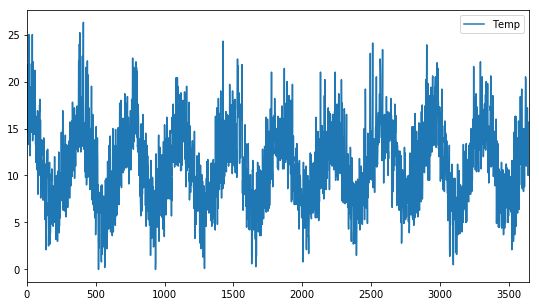

In [0]:
df.plot()
plt.show()


### Conjunto de amostras e subcojuntos 
Como especificado no material o último ano foi reservado como conjunto de teste







In [0]:
df.loc[df['Date'] == "1990-01-01"]

,Date,Temp
3285,1990-01-01,14.8




---


##Preditor Linear 
*  O número máximo de atributos de entrada a serem testados foi de 30. 
Para validação cruzada um total de 7 pastas foram utilizadas.
*  O valor médio da raiz quadrada do erro quadrático médio (RMSE - Root Mean Squared Error) de cada pasta foi guardado.
*  O número de atrasos que gerou o mínimo *RMSE* foi obtido.
*  Foi gerado um preditor para o número de atrasos obtido levando em consideração todo o conjunto de treinamento.
*  Por fim, foi feita a comparação entre a série temporal e as estimativas.


###Atraso que mínimiza *RMSE*

RMSE: 0.18951668076129163
Atrasos: 8


<function matplotlib.pyplot.show>

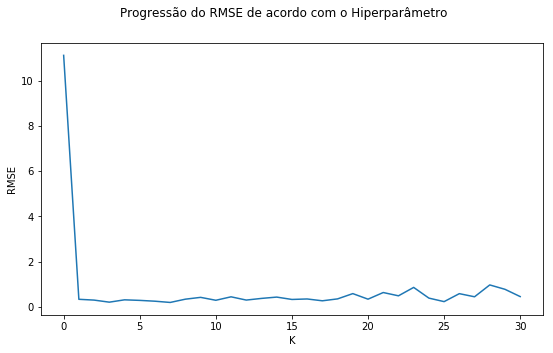

In [0]:
database = df.iloc[:3285,1].values
temp = []
y = []
predictor = [] 
H = 30
k = 7
rms_h = []
rms_min = 10

for h in range(0,H+1):
  theta = []
  y = []
  for t in range(h, len(database), h+1):
    temp = []
    for p in range(t-h,t):
      temp.append(database[p])
    theta.append(temp) 
    y.append(database[t])
  predictor = (theta,y)
  index = list(range(len(theta)))  
  size = round(len(index)/k)
  subsets = []
  kfolds = []
  
  for x in range(0, len(index), size):
    subsets.append(index[x:x+size]) 

  for i in range(k):
    test = subsets[i]
    train = []
    for subset in subsets:
      if subset != test:
        train.append(subset)
    kfolds.append((train, test))
  
  rms_fold = [] 
  for train, test in kfolds:
    theta = []
    y = []
    for tr in train:
      for i in tr:
        theta.append(predictor[0][i])
        y.append(predictor[1][i])  
    theta = np.asarray(theta)  
    y = np.asarray(y)
    w = la.inv(theta.T.dot(theta)).dot(theta.T).dot(y) 
    x = []
    y = []
    for ts in test:
      x.append(predictor[0][ts])
      y.append(predictor[1][ts])  
    x = np.asarray(x)  
    y = np.asarray(y)
    yhat = x.dot(w)
    rms = np.sqrt(np.mean((y-yhat))**2)
    rms_fold.append(rms)
  rms_mean = np.mean(rms_fold)
  rms_h.append(rms_mean)
  if(rms_mean < rms_min):
    rms_min = rms_mean
    w_min = w

rms_min = rms_min
lag = rms_h.index(rms_min)+1 
print('RMSE:',rms_min)
print('Atrasos:',lag)  
plt.plot(rms_h)
plt.suptitle('Progressão do RMSE de acordo com o Hiperparâmetro')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show      

###Treinamento com atraso definido
Uma vez que o número de atrasos que miniza o erro quadrático médio foi identificado, novos coeficintes para regressão foram encontrados para esse atraso, porém agora levando em conta o conjunto de treinamento como um todo.



In [0]:
database = df.iloc[:3285,1].values
theta = []
y = []
for t in range(lag, len(database),lag):
  temp = []
  for p in range(t-lag,t):
    temp.append(database[p])
  theta.append(temp) 
  y.append(database[t])
theta = np.asarray(theta)  
y = np.asarray(y)
w_min = la.inv(theta.T.dot(theta)).dot(theta.T).dot(y)


###Teste
Finalmente, aplicando o preditor obtido no conjunto de teste foi obtida a comparação entre os valores da série temporal com as respectivas estimativas

RMSE: 2.320285925270024


<function matplotlib.pyplot.show>

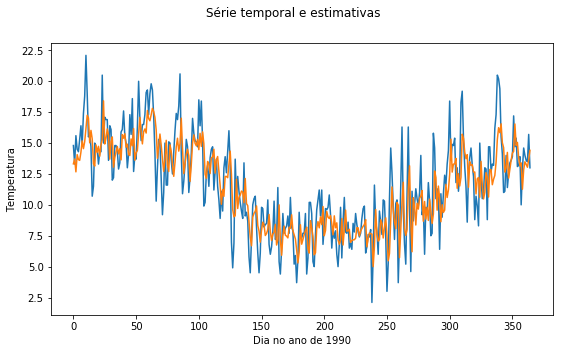

In [0]:
start_index = 3285 - lag
test_db = df.iloc[start_index:]
test_db = test_db['Temp'].values

predicted = []
y = []
rms_test = []

for day in range(lag, len(test_db - start_index)):
  theta = []
  for i in range(day-lag, day):
    theta.append(test_db[i])
  theta = np.asarray(theta)
  y.append(test_db[day])
  yhat = theta.dot(w_min)
  predicted.append(yhat)
y = np.asarray(y)
predicted = np.asarray(predicted)
rmse = np.sqrt(np.mean((y-predicted)**2))

print('RMSE:', rmse)
plt.plot(test_db[lag:], label="Série")
plt.plot(predicted, label="Estimativa")
plt.suptitle('Série temporal e estimativas')
plt.xlabel('Dia no ano de 1990')
plt.ylabel('Temperatura')
plt.show          

##Preditor Linear com entradas de transfomeações não-lineares
*  O número de atrasos foi definido em 5.
*  O número máximo de atributos gerados foi 100.
*  Para evitar a saturação da tangente hiperbólica cada atributo gerado respeitou uma distribuição uniforme do tipo [0 , 0,01)
*  O coeficiente de regularização $\lambda$ foi avaliado de 10<sup>-18</sup> a 10<sup>2</sup> em intervalos de 1 para seu expoente.
*  O $\lambda$ que minimiza o *RMSE* para o número de atributos sendo avaliado foi guardado.
*  Para validação cruzada um total de 7 pastas foram utilizadas.
*  O valor médio da *RMSE* de cada pasta foi guardado.
*  O número de atributos gerados que proporcionou o mínimo *RMSE* foi obtido.
*  Foi gerado um preditor para o número de atributos ótimo levando em consideração todo o conjunto de treinamento.
*  Por fim, foi feita a comparação entre a série temporal e as estimativas.

###Número de atributos gerados que mínimiza *RMSE*

RMSE: 2.726099544370646
Atributos: 33
Lambda: 1e-14


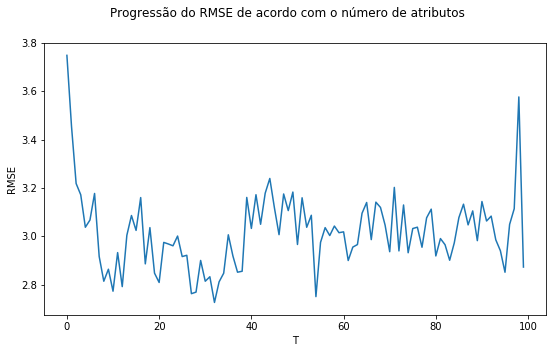

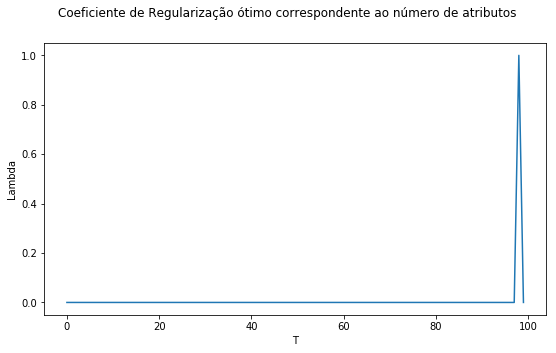

In [0]:
database  = df.iloc[:3285,1].values
temp = []
theta = []
y = []
predictor = [] 
H = 5
k = 7
T = 100
rms_T = []
lmbda_T = []
rms_min = 10

for atr in range(1,T+1):
  theta = []
  y = []
  for t in range(H, len(database), H+1):
    wk = np.random.uniform(0,0.01,size=[H,atr])
    temp = []
    for p in range(t-H,t):
      temp.append(database[p])
    temp = np.asarray(temp)
    temp = np.tanh(temp.dot(wk))
    theta.append(temp)
    y.append(database[t])
  predictor = (theta,y)

  index = list(range(len(theta)))  
  size = round(len(index)/k)
  subsets = []
  kfolds = []
  
  for x in range(0, len(index), size):
    subsets.append(index[x:x+size]) 

  for i in range(k):
    test = subsets[i]
    train = []
    for subset in subsets:
      if subset != test:
        train.append(subset)
    kfolds.append((train, test))
    
  rms_fold = []
  rms_lmbda_min = 10
  for train, test in kfolds:
    for l in range(2,-20,-1):
      lmbda = pow(10,l)
      theta = []
      y = []
      for t in train:
        for i in t:
          theta.append(predictor[0][i])
          y.append(predictor[1][i])  
      theta = np.asarray(theta)  
      y = np.asarray(y)
      w = la.inv(theta.T.dot(theta)+lmbda*np.eye(theta.shape[1])).dot(theta.T).dot(y)
      x = []
      y = []
      for ts in test:
        x.append(predictor[0][ts])
        y.append(predictor[1][ts])  
      x = np.asarray(x)  
      y = np.asarray(y)
      yhat = x.dot(w)
      rms = np.sqrt(np.mean((y-yhat)**2)+lmbda*np.mean((w)**2))
      if(rms < rms_lmbda_min):
        rms_lmbda_min = rms
        lmbda_min = lmbda
        rms_fold.append(rms_lmbda_min)
  rms_mean = np.mean(rms_fold)
  lmbda_T.append(lmbda_min)
  rms_T.append(rms_mean)
  if(rms_mean < rms_min):
    rms_min = rms_mean
    atr_min = atr
    lmbda_min = lmbda_T[atr_min-1]
    w_min = w
    wk_min = wk

print('RMSE:', rms_min)
print('Atributos:', atr_min)
print('Lambda:', lmbda_min)  
plt.plot(rms_T)
plt.suptitle('Progressão do RMSE de acordo com o número de atributos')
plt.xlabel('T')
plt.ylabel('RMSE')
plt.show()
plt.suptitle('Coeficiente de Regularização ótimo correspondente ao número de atributos')
plt.xlabel('T')
plt.ylabel('Lambda')
plt.plot(lmbda_T)
plt.show()

###Treinamento com número de atributos definido
Uma vez que o número de atributos que miniza o erro quadrático médio foi identificado, novos coeficintes para regressão foram encontrados para esse número de atributos, porém agora levando em conta o conjunto de treinamento como um todo.

In [0]:
database  = df.iloc[:3285,1].values
temp = []
theta = []
y = []
wk_T = []
w_min
H = 5
T = atr_min
wk_T = []

for t in range(H, len(database),H+1):
  wk = np.random.uniform(0,0.01,size=[H,T])
  wk_T.append(wk)
  temp = []
  for p in range(t-H,t):
    temp.append(database[p])
  temp = np.asarray(temp)
  temp = np.tanh(temp.dot(wk))
  theta.append(temp)
  y.append(database[t])

theta = np.asarray(theta)  
y = np.asarray(y)
w_min = la.inv(theta.T.dot(theta)+lmbda*np.eye(theta.shape[1])).dot(theta.T).dot(y)


###Teste
Finalmente, aplicando o preditor obtido no conjunto de teste foi obtida a comparação entre os valores da série temporal com as respectivas estimativas

RMSE: 2.5994461492516336


<function matplotlib.pyplot.show>

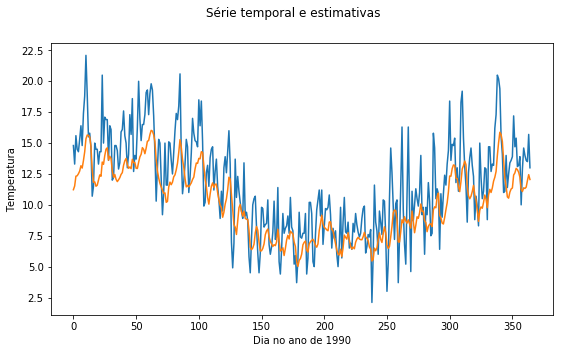

In [0]:
start_index = 3285 - H
test_db = df.iloc[start_index:]
test_db = test_db['Temp'].values

predicted = []
theta = []
y = []

for day in range(H, len(test_db - start_index)):
  temp = []
  for i in range(0, H):
    temp.append(test_db[day-i])
  temp = np.asarray(temp)
  temp = np.tanh(temp.dot(wk_T[i]))
  y.append(test_db[day])
  theta = np.asarray(temp)
  yhat = theta.dot(w_min)
  predicted.append(yhat)
y = np.asarray(y)
predicted = np.asarray(predicted)
rmse = np.sqrt(np.mean((y-predicted)**2))
      
print('RMSE:', rmse)
plt.plot(test_db[H:], label="Série")
plt.plot(predicted, label="Estimativa")
plt.suptitle('Série temporal e estimativas')
plt.xlabel('Dia no ano de 1990')
plt.ylabel('Temperatura')
plt.show       